# Setting

In [1]:
import bt
import FinanceDataReader as fdr
import pandas as pd

from pf_utils import import_tdfs
from pf_utils import Backtest, get_date_range, metrics

In [2]:
path_data = 'data'

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Data

## TDF
- https://www.kiwoomam.com/fund/KI0202020000M?parentfundcode=8325&fundcode=8335
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537380&childFundGb=2&childFundCd=53738P
- https://www.hanwhawm.com/main/finance/fundInfo/FI141_2.cmd?p=500&item_cd=5102896

In [4]:
file = '금융자산운용 - export.csv'
df = pd.read_csv(f'{path_data}/{file}')

In [5]:
tdf_names = df.set_index('ticker')['name'].to_dict()
commissions = df.set_index('ticker')['commission'].to_dict()
{tdf_names[k]:v for k,v in commissions.items()}

{'미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e': 0.6,
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)': 0.48,
 '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e': 0.54,
 '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e': 0.74,
 '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)': 0.68}

In [6]:
tdf_dict = dict()
for x in df.to_dict(orient='records'):
    k = x['data_type']
    if k not in tdf_dict: # init dict of data type k
        tdf_dict[k] = dict()
    
    kt = x['ticker']
    tdf_dict[k][kt] = {
        'name': x['name'],
        'file': f"{x['file']}.csv",
        'path': path_data,
        'commission': x['commission'],
        'data_check': [
            (x['check1_date'], x['check1_price']),
            (x['check2_date'], x['check2_price'])
        ]
    }

In [7]:
df_tdf_all = None
for k, v in tdf_dict.items():
    df_tdf_all = import_tdfs(v, df_tdf_all=df_tdf_all, data_type=k)
    
df_tdf_all.head()

error: -0.07 %
error: 0.16 %
error: -0.13 %
error: -0.00 %
error: 0.00 %


,K55301BU6139,K55301BU5453,K55301BU5479,K55206C95800,K55206C96311
date,,,,,
2017-08-14,NaN,NaN,1001.091988,NaN,NaN
2017-08-15,NaN,NaN,1001.091988,NaN,NaN
2017-08-16,NaN,NaN,1007.198649,NaN,NaN
2017-08-17,NaN,NaN,1011.603454,NaN,NaN
2017-08-18,NaN,NaN,1008.29985,NaN,NaN


In [8]:
df = get_date_range(df_tdf_all)
df

,start date,end date
K55301BU5479,2017-08-14,2024-06-16
K55301BU6139,2017-09-20,2024-06-16
K55301BU5453,2017-09-29,2024-06-16
K55206C96311,2018-07-13,2024-06-17
K55206C95800,2018-07-26,2024-06-13


In [11]:
start_date = df['start date'].max()
end_date = df['end date'].min()
end_date

Timestamp('2024-06-13 00:00:00')

In [12]:
df_tdf = df_tdf_all.loc[start_date:end_date]

In [16]:
df_tdf.isna().sum().div(df_tdf.count())

K55301BU6139    0.000465
K55301BU5453    0.000465
K55301BU5479    0.000465
K55206C95800    0.477663
K55206C96311    0.477663
dtype: float64

<Axes: xlabel='date'>

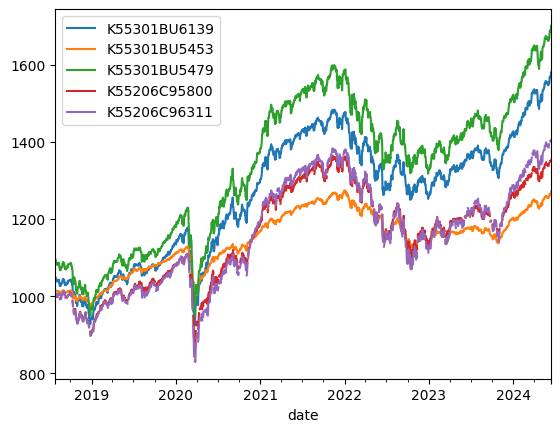

In [14]:
df_tdf.plot()

In [17]:
df_tdf = df_tdf.ffill()

In [18]:
df_tdf

,K55301BU6139,K55301BU5453,K55301BU5479,K55206C95800,K55206C96311
date,,,,,
2018-07-26,1050.118219,1015.894964,1096.295836,1001.884133,1003.586555
2018-07-27,1049.417539,1015.794609,1095.294744,1002.886017,1004.286755
2018-07-28,1049.417539,1015.894964,1095.294744,1002.886017,1004.286755
2018-07-29,1049.417539,1015.894964,1095.294744,1002.886017,1004.286755
2018-07-30,1046.114336,1015.393188,1091.090158,1004.689409,1006.587412
...,...,...,...,...,...
2024-06-09,1568.220582,1265.478168,1686.840000,1343.426434,1389.496744
2024-06-10,1567.620000,1263.170000,1686.840000,1350.640000,1400.900000
2024-06-11,1570.422718,1264.173551,1689.943385,1349.337551,1400.799971


## ETF

In [37]:
file = 'etfs_selected_240611.csv'
df_etf_all = pd.read_csv(f'{path_data}/{file}', parse_dates=[0], index_col=0)
df_etf_all.head()

,273130,453850,284430,069500,379800,411060,305080,304660,148070,261220
Date,,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_sym = fdr.StockListing('ETF/KR') # 한국 ETF 전종목

symbols = df_etf_all.columns
etf_names = df_sym.loc[df_sym.Symbol.isin(symbols)].set_index('Symbol')['Name'].to_dict()
etf_names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합',
 '261220': 'KODEX WTI원유선물(H)'}

In [39]:
#etf = ['069500', '148070', '305080', '379800']
etf = ['069500', '273130', '148070', '379800']
{x: etf_names[x] for x in etf}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800': 'KODEX 미국S&P500TR'}

In [40]:
df_etf = df_etf_all[etf]

In [75]:
get_date_range(df_etf)

,start date,end date
069500,2002-10-14,2024-06-11
148070,2011-10-20,2024-06-11
273130,2017-06-29,2024-06-11
379800,2021-04-09,2024-06-11


# Backtest

In [42]:
asset_names = etf_names.copy()
asset_names.update(tdf_names)
asset_names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합',
 '261220': 'KODEX WTI원유선물(H)',
 'K55301BU6139': '미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 'K55206C95800': '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)',
 'K55301BU5453': '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e',
 'K55301BU5479': '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e',
 'K55206C96311': '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)'}

In [62]:
bts = Backtest(metrics, initial_capital=10000000,
              asset_names=asset_names, 
              commissions=None)

## Baseline

In [63]:
name = 'KOSPI'
index = df_tdf.index
df = df_etf.loc[index.min():index.max(), '069500']
bts.buy_n_hold(df, name=name)

## TDF

In [64]:
[asset_names[x] for x in df_tdf.columns]

['미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e',
 '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e',
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)',
 '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)']

In [65]:
name = 'TDF COMB'
weights = [0.5, 0, 0, 0.5, 0]
weights = dict(zip(df_tdf.columns, weights))
bts.build(df_tdf, weights, name, period='Y')

In [56]:
name = 'TDF COMB w/fee'
bts.build(df_tdf, weights, name, period='Y', commissions=commissions)

In [67]:
name = 'TDF COMB DCA'
bts.build(df_tdf, weights, name, period='M', 
          initial_capital=0, capital_flow=1000000)

In [60]:
name = 'TDF COMB DCA w/fee'
bts.build(df_tdf, weights, name, period='M', 
          initial_capital=0, capital_flow=1000000, commissions=commissions)

## ETF

In [69]:
[asset_names[x] for x in df_etf.columns]

['KODEX 200', 'KODEX 종합채권(AA-이상)액티브', 'KOSEF 국고채10년', 'KODEX 미국S&P500TR']

In [73]:
df_etf

,069500,273130,148070,379800
Date,,,,
2002-10-14,5184,NaN,NaN,NaN
2002-10-15,5312,NaN,NaN,NaN
2002-10-16,5335,NaN,NaN,NaN
2002-10-17,5410,NaN,NaN,NaN
2002-10-18,5642,NaN,NaN,NaN
...,...,...,...,...
2024-06-04,36390,110605.0,111850.0,16500.0
2024-06-05,36755,110820.0,112200.0,16530.0
2024-06-07,37240,111075.0,112610.0,16625.0


In [70]:
name = 'ETF COMB1'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etf, weights))
bts.build(df_etf, weights, name, period='Y')

In [71]:
name = 'ETF COMB2'
weights = [0.3, 0.2, 0.3, 0.2]
weights = dict(zip(etf, weights))
bts.build(df_etf, weights, name, period='Y')

In [40]:
name = 'TDF COMB DCA2'
weights = [0.5, 0.5]
weights = dict(zip(df_tdf.columns, weights))
bts.build(df_tdf, weights, name, period='Q', 
          #initial_capital=0, 
          capital_flow=5000000, commissions=commissions)

In [72]:
bts.run(figsize=(12,4))

Exception: Cannot allocate capital to 273130 because price is nan as of 2002-10-14 00:00:00

,KOSPI,TDF COMB,TDF COMB w/fee,TDF COMB DCA,TDF COMB DCA w/fee,TDF COMB DCA2
start,2021-06-13 00:00:00,2021-06-13 00:00:00,2021-06-13 00:00:00,2021-06-13 00:00:00,2021-06-13 00:00:00,2021-06-13 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.090013,0.069546,0.063616,0.063157,0.060573,0.073177
cagr,-0.031001,0.022701,0.020805,0.020657,0.019828,0.023859
max_drawdown,-0.341902,-0.174037,-0.174037,-0.16719,-0.167638,-0.155756
avg_drawdown,-0.120892,-0.020254,-0.022007,-0.022642,-0.019246,-0.014384
avg_drawdown_days,361.666667,73.714286,79.692308,93.727273,79.846154,63.875
daily_vol,0.168907,0.065375,0.065447,0.062148,0.062142,0.056801
daily_sharpe,-0.106629,0.384331,0.354932,0.368015,0.354648,0.453524
daily_sortino,-0.181655,0.61664,0.569367,0.588259,0.566921,0.735584


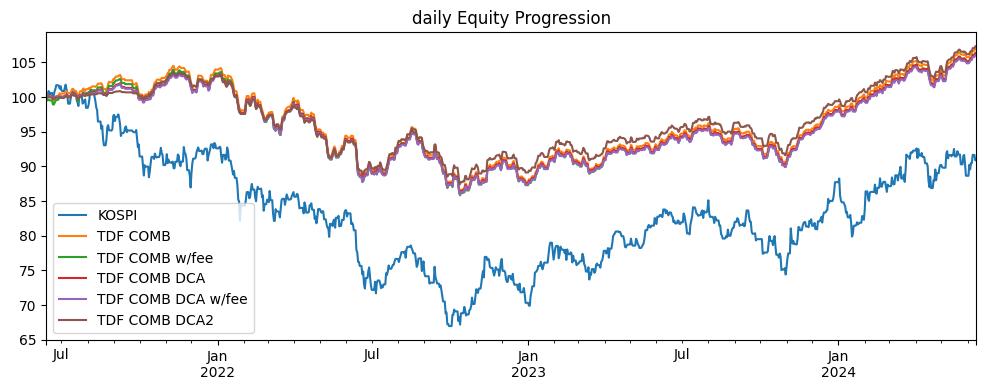

In [42]:
bts.run([0,1,2,3,4,7], figsize=(12,4))

,KOSPI,TDF COMB,TDF COMB DCA,ETF COMB1,ETF COMB2
start,2021-06-13 00:00:00,2021-06-13 00:00:00,2021-06-13 00:00:00,2021-06-13 00:00:00,2021-06-13 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.090013,0.069546,0.063157,0.142346,0.079898
cagr,-0.031001,0.022701,0.020657,0.045434,0.025995
max_drawdown,-0.341902,-0.174037,-0.16719,-0.142306,-0.164024
avg_drawdown,-0.120892,-0.020254,-0.022642,-0.011646,-0.013907
avg_drawdown_days,361.666667,73.714286,93.727273,35.821429,46.909091
daily_vol,0.168907,0.065375,0.062148,0.076027,0.078517
daily_sharpe,-0.106629,0.384331,0.368015,0.636573,0.373979
daily_sortino,-0.181655,0.61664,0.588259,1.046522,0.619614


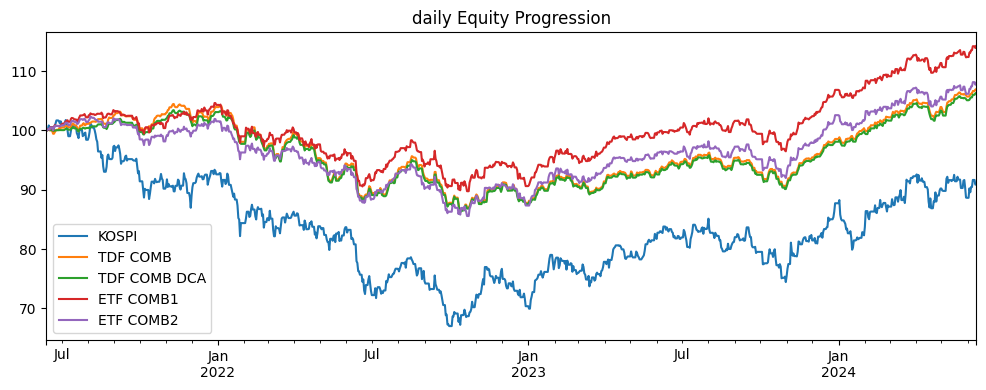

In [43]:
bts.run([0,1,3,5,6], figsize=(12,4))

In [32]:
bts.show_weights(name='ETF COMB1')

KODEX 200               0.2
KODEX 종합채권(AA-이상)액티브    0.2
KOSEF 국고채10년            0.3
KODEX 미국S&P500TR        0.3
dtype: float64

# Scaled

## Data

In [20]:
etf = ['069500', '273130', '148070', '379800']
{x: etf_names[x] for x in etf}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800': 'KODEX 미국S&P500TR'}

In [21]:
get_start_dates(df_etf_all[etf])

,start date
069500,2002-10-14
148070,2011-10-20
273130,2017-06-29
379800,2021-04-09


In [22]:
start_date = '2017-06-29'

In [23]:
df_snp = fdr.DataReader('S&P500')
df_snp = df_snp['Adj Close'].rename('S&P500')

In [24]:
df_rate = df_snp/df_snp[0]-1
df_rate

Date
1980-01-02     0.000000
1980-01-03    -0.005106
1980-01-04     0.007186
1980-01-07     0.009928
1980-01-08     0.030163
                ...    
2024-06-10    49.688256
2024-06-11    49.825640
2024-06-12    50.257845
2024-06-13    50.378027
2024-06-14    50.357791
Name: S&P500, Length: 11208, dtype: float64

In [25]:
df_379800 = df_etf_all['379800'].dropna()
df_379800.head()
df_379800.tail()

Date
2024-06-04    16500.0
2024-06-05    16530.0
2024-06-07    16625.0
2024-06-10    16695.0
2024-06-11    16770.0
Name: 379800, dtype: float64

In [26]:
data_check = [
    ('2024-06-11', 16770.0),
    ('2021-04-09', 10085.0)
]
df_snp_r = get_price(df_rate, data_check, rate_is_percent=False)
df_snp_r = df_snp_r.rename('S&P500_R')

error: 27.73 %


<Axes: xlabel='Date'>

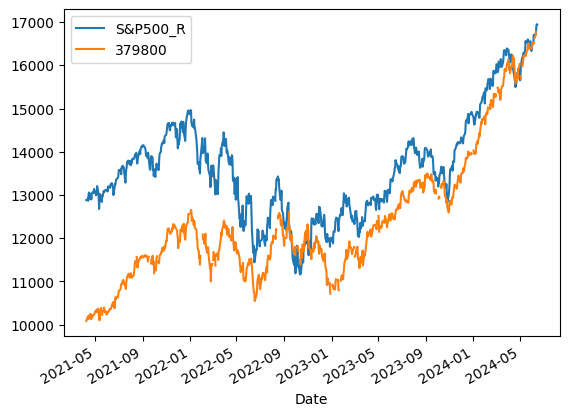

In [27]:
dt = '2021-04-09'
df_snp_r.to_frame().join(df_379800).loc[dt:].plot()

In [28]:
etf2 = ['069500', '273130', '148070']
df_etf = df_etf_all[etf2].join(df_snp_r).loc[start_date:]
df_etf = df_etf.ffill()
df_etf

,069500,273130,148070,S&P500_R
Date,,,,
2017-06-29,27193,99855.0,106044.0,7549.014665
2017-06-30,27109,99810.0,105817.0,7560.589054
2017-07-03,27170,99745.0,105613.0,7578.060320
2017-07-04,27002,99655.0,105190.0,7578.060320
2017-07-05,27105,99620.0,105253.0,7589.073356
...,...,...,...,...
2024-06-04,36390,110605.0,111850.0,16507.998052
2024-06-05,36755,110820.0,112200.0,16703.579031
2024-06-07,37240,111075.0,112610.0,16681.616938


In [29]:
df_etf = df_etf.ffill()

In [33]:
asset_names.update({'S&P500_R':'KODEX 미국S&P500TR Assumed'})

In [34]:
df_etf

,069500,273130,148070,S&P500_R
Date,,,,
2017-06-29,27193,99855.0,106044.0,7549.014665
2017-06-30,27109,99810.0,105817.0,7560.589054
2017-07-03,27170,99745.0,105613.0,7578.060320
2017-07-04,27002,99655.0,105190.0,7578.060320
2017-07-05,27105,99620.0,105253.0,7589.073356
...,...,...,...,...
2024-06-04,36390,110605.0,111850.0,16507.998052
2024-06-05,36755,110820.0,112200.0,16703.579031
2024-06-07,37240,111075.0,112610.0,16681.616938


## Backtest

In [35]:
bts = Backtest(metrics, initial_capital=10000000,
               asset_names=asset_names, 
               commissions=None)

In [36]:
name = 'KOSPI'
df = df_etf['069500']
bts.buy_n_hold(df, name=name)

In [37]:
name = 'ETF COMB1'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(df_etf.columns, weights))
bts.build(df_etf, weights, name, period='Y')

In [38]:
name = 'ETF COMB1 (M)'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(df_etf.columns, weights))
bts.build(df_etf, weights, name, period='M', capital_flow=1000000)

In [39]:
name = 'ETF COMB2'
weights = [0.3, 0.2, 0.3, 0.2]
weights = dict(zip(df_etf.columns, weights))
bts.build(df_etf, weights, name, period='Y')

,KOSPI,ETF COMB1,ETF COMB1 (M),ETF COMB2
start,2017-06-28 00:00:00,2017-06-28 00:00:00,2017-06-28 00:00:00,2017-06-28 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.359183,0.450954,0.430813,0.383078
cagr,0.045118,0.054983,0.052865,0.04774
max_drawdown,-0.380162,-0.189178,-0.190569,-0.20192
avg_drawdown,-0.047992,-0.012449,-0.012622,-0.015412
avg_drawdown_days,94.576923,26.809524,27.47561,39.288136
daily_vol,0.184222,0.078006,0.078233,0.077309
daily_sharpe,0.337775,0.743129,0.714828,0.657651
daily_sortino,0.555855,1.165093,1.118762,1.04768


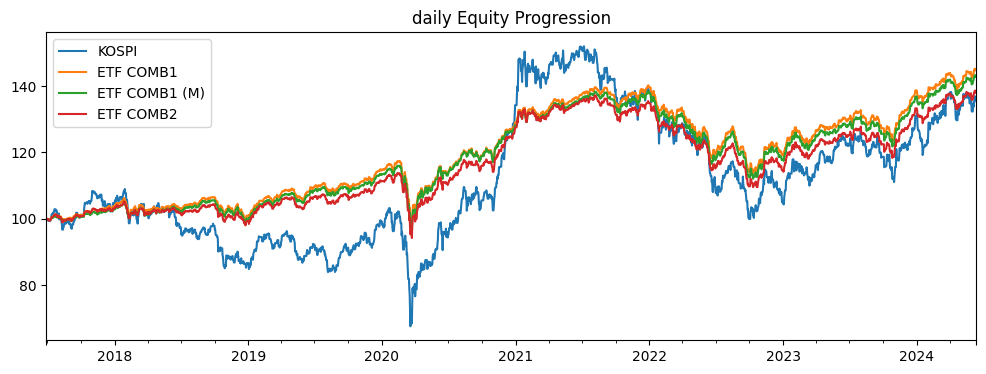

In [40]:
bts.run(figsize=(12,4))

In [41]:
bts.show_weights('ETF COMB1')

KODEX 200                   0.2
KODEX 종합채권(AA-이상)액티브        0.2
KOSEF 국고채10년                0.3
KODEX 미국S&P500TR Assumed    0.3
dtype: float64

In [134]:
bts.show_weights('ETF COMB2')

KODEX 200                   0.3
KODEX 종합채권(AA-이상)액티브        0.2
KOSEF 국고채10년                0.3
KODEX 미국S&P500TR Assumed    0.2
dtype: float64